#Predicting Earnings with XGBRegressor

In this notebook, our objective is to evaluate the effectiveness of XGBoost. The dataset selected for this analysis possesses a moderate size, significant variance, and multiple labels within its features. With this challenging dataset, we are poised to uncover the capabilities of XGBoost in handling diverse data structures. Let's proceed with our in-depth exploration to gauge the potential of XGBoost in predictive modeling.

#Import the necessary libraries

In [1]:
!pip install opendatasets
!pip install category_encoders
import opendatasets as od
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 824.2 kB/s eta 0:00:00


#About Dataset
Explore the salaries of higher education employees from Ohio's public universities dating back to 2011.

This dataset offers insights into the earnings of various positions across multiple institutions. Please note that benefits are not included in the reported salaries.

In [2]:
datasetlink = "https://www.kaggle.com/datasets/asaniczka/university-employee-salaries-2011-present"
od.download(datasetlink)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kidkeozz
Your Kaggle Key: ··········


100%|██████████| 17.5M/17.5M [00:00<00:00, 89.5MB/s]


In [3]:
os.chdir("university-employee-salaries-2011-present")
os.listdir()

['higher_ed_employee_salaries.csv']

#Let's see how the first 10 rows of the dataset look

In [30]:
archivo = 'higher_ed_employee_salaries.csv'
df = pd.read_csv(archivo)
df.head(10)

,Name,School,Job Description,Department,Earnings,Year
0,Don Potter,University of Akron,Assistant Lecturer,Social Work,2472.00,2019
1,Emily Potter,The Ohio State University,Administrative Assistant 3,Arts and Sciences | Chemistry and Biochemistry...,48538.02,2022
2,Carol Jean Potter,The Ohio State University,Associate Professor-Clinical,Pediatrics,22722.80,2013
3,Kim Potter,The Ohio State University,"Manager 4, Compliance",Legal Affairs | Compliance,170143.44,2022
4,Graham Potter,Miami University,Building and Grounds Assistant,"Assoc VP Housing,Dining,Rec,Bus Svc",3075.20,2012
5,Amanda Potter,The Ohio State University,Program Coordinator,WCA-Education,48806.72,2013
6,Susan Marie Potter,The Ohio State University,Program Manager,College of Nursing,65216.00,2013
7,Katrina Potter,Miami University,Personnel Technician,VP for Acad Affrs-Provost,24324.14,2012
8,Pamela Lynn Potter,Bowling Green State University,Administrative Assistant 2,Center for Teaching & Learning,51496.58,2012
9,Kimberly J Potter,The Ohio State University,Policy Anlyst/Compliance Offcr,Legal Affairs Administration,20868.00,2015


#Exploring Extensive Dataset Dimensions

The dataset presents a considerable volume of information, consisting of 934.348 rows across 6 columns. Analyzing such a substantial dataset offers a rich opportunity to extract valuable insights and construct reliable predictive models. However, we have a lot to do in terms of cleaning and preprocessing the data. After completing these tasks, we will observe how the shape of the dataframe changes.

In [31]:
# How we see, we have 934348 rows and 6 columns thats a lot
fs=df.shape
print('Original shape : {}'.format(fs))

#Dropping duplicate values
df = df.drop_duplicates()

# How we see, now we have 801136 rows and 6 columns thats a lot
ns= df.shape
print('There were {} duplicates'.format((fs[0])-(ns[0])))
print('New shape : {}'.format(ns))

Original shape : (934348, 6)
There were 133212 duplicates
New shape : (801136, 6)


In [32]:
#More information about the dataset and the data type of each column.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801136 entries, 0 to 934347
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             801136 non-null  object 
 1   School           801136 non-null  object 
 2   Job Description  778573 non-null  object 
 3   Department       750021 non-null  object 
 4   Earnings         792807 non-null  float64
 5   Year             801136 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 42.8+ MB


In [33]:
#check if we have any nulls in the dataset.
df.isnull().sum()

Name                   0
School                 0
Job Description    22563
Department         51115
Earnings            8329
Year                   0
dtype: int64

In [34]:
#df['Earnings'] = df['Earnings'].round(0)
print('The variance of the target value before : {}'.format(df['Earnings'].var()))

#Dropping Earnings null values that how we see above there are 8329 null values
df = df[~df['Earnings'].isnull()]

#Dropping Earnings values that are so small
df = df[df['Earnings'] >=10000]
#include only the rows where the value in the 'Earnings' column is greater than the 1st percentile and less than the 99th percentile, effectively removing outliers and retaining the central 98% of the 'Earnings' data.
P = np.percentile(df['Earnings'], [1, 99])
df = df[(df['Earnings'] > P[0]) & (df['Earnings'] < P[1])]
print('The variance of the target value after : {}'.format(df['Earnings'].var()))

The variance of the target value before : 3862861213.0967145
The variance of the target value after : 1736621283.358481


In [36]:
#Metrics of the distribution of all numeric features in the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Earnings,640398.0,62468.809222,41672.788284,10920.01,35000.0,52500.11,77820.7,299676.28
Year,640398.0,2017.163411,3.173576,2011.00,2015.0,2017.00,2020.0,2022.00


In [37]:
#Check for any null values in the dataset.
df.isnull().sum()

Name                   0
School                 0
Job Description    15338
Department         44663
Earnings               0
Year                   0
dtype: int64

#EDA
is the initial step in discovering patterns within the data through visualizations and filtering techniques. It involves thoroughly examining the dataset to understand its main characteristics and gain insights to shape subsequent analysis and decision-making.

In [38]:
print('# of departments {}'.format(len(df['Department'].unique())))

# of departments 8842


In [39]:
#Top 10 departments with the most records
df['Department'].value_counts().head(10)

Department
University Hospitals              33363
Cancer Hosp & Research Instit     25195
University                        17386
Health System                     14945
Shared Services                   10177
University Hospitals East          8586
Internal Medicine                  7131
Ross Heart Hospital                6273
Comprehensive Cancer Center RU     4715
Pediatrics                         4104
Name: count, dtype: int64

In [40]:
print('# of jobs {}'.format(len(df['Job Description'].unique())))

# of jobs 34854


In [41]:
#Top 10 departments with the most records
df['Job Description'].value_counts().head(10)

Job Description
Professor                       23528
Associate Professor             21128
Assistant Professor             15611
Staff Nurse-B                   15171
Clinical Inst HS                 9519
Lecturer                         7943
Custodial Worker                 7578
Patient Care Associate           6983
Assistant Professor-Clinical     5838
Staff Nurse                      5334
Name: count, dtype: int64

In [42]:
#Dropping Department null values that how we see above there are 44663 null values
df = df[~df['Department'].isnull()]

#Dropping Department null values that how we see above there are 15338 null values
df = df[~df['Job Description'].isnull()]

In [44]:
df.isnull().sum()

Name               0
School             0
Job Description    0
Department         0
Earnings           0
Year               0
dtype: int64

In [67]:
df = df.reset_index().drop(columns='index')

In [76]:
#Top 10 jobs with the most salary mean
top_10_jobs=df.groupby("Job Description")['Earnings'].mean().reset_index(name='salary mean').sort_values(by='salary mean', ascending=False).head(10)
top_10_jobs

,Job Description,salary mean
10233,Corporate Controller (HS),299676.28
29248,VP for U Advancement,299129.33
17426,Int VP D&I/Dean Coll Arts&Ltrs,298334.82
22871,"Prof Pract, Accountancy",298267.00
23822,Provost & Sr VP Acad Affairs,297639.08
14923,"Exec VP, CPM",297600.00
27215,"Sr VP, Strat Comm & Ext Affair",297279.00
10772,"Dean, College Of Business",297212.50
95,ARMCO Alumni Assoc Professor,296836.48
8424,Chief Operating Officer - UTMC,296584.62


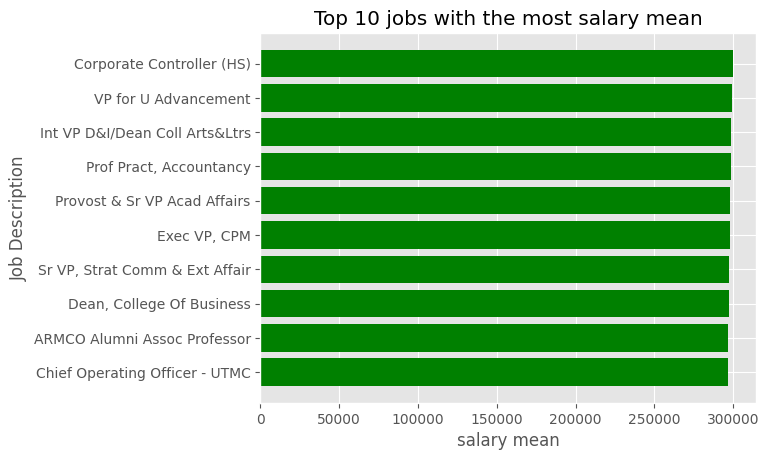

In [85]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.barh(top_10_jobs['Job Description'],top_10_jobs['salary mean'],color='green' )
ax.set_title('Top 10 jobs with the most salary mean')
ax.set_xlabel('salary mean')
ax.set_ylabel('Job Description')
plt.gca().invert_yaxis()
plt.show()

In [78]:
#Top 10 departments with the highest average salaries
top_10_depar=df.groupby("Department")['Earnings'].mean().reset_index(name='salary mean').sort_values(by='salary mean', ascending=False).head(10)
top_10_depar

,Department,salary mean
8485,VP for Legal Affairs and General Counsel,292875.130000
4750,Human Resources | Shared Services,281873.420000
593,Academic Affairs Administration | External Eng...,274331.670000
5761,Medicine | Internal Medicine Infectious Disease,264155.573333
2133,COM Pediatrics,248897.707500
4060,FGP-Radiology,235469.806667
3802,Executive VP to the President,230000.000000
4061,FGP-Spine/Neuro,229527.408000
595,Academic Affairs Administration | Inclusive Ex...,220188.600000
5753,Medicine | IM Hospital Medicine,217040.445522


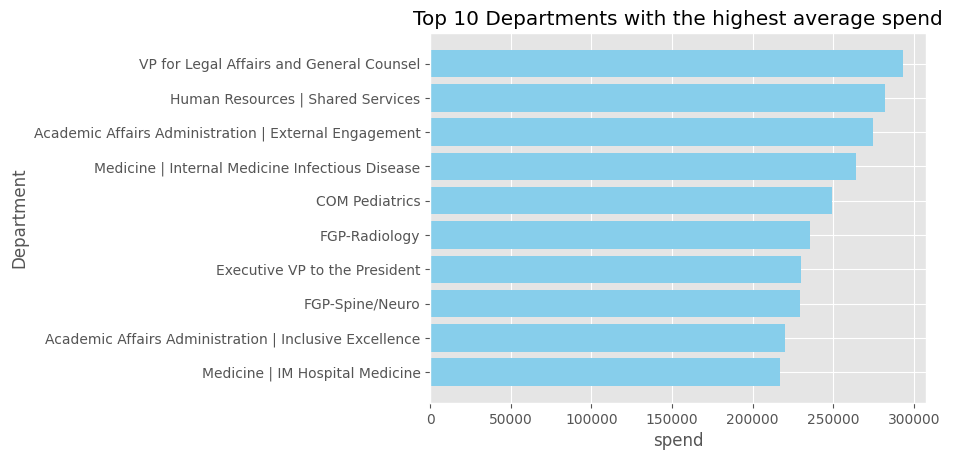

In [84]:
fig, ax = plt.subplots()
ax.barh(top_10_depar['Department'],top_10_depar['salary mean'],color='skyblue' )
ax.set_title('Top 10 Departments with the highest average spend')
ax.set_xlabel('spend')
ax.set_ylabel('Department')
plt.gca().invert_yaxis()
plt.show()

In [81]:
#Total expenditure on salaries per university
total_spend=df.groupby("School")['Earnings'].sum().reset_index(name='total spend').sort_values(by='total spend', ascending=False).head(13)
total_spend.T

,7,10,3,4,5,11,8,0,12,2,9,1,6
School,The Ohio State University,University of Toledo,Kent State University,Miami University,Ohio University,Wright State University,University Of Cincinnati,Bowling Green State University,Youngstown State University,Cleveland State University,University of Akron,Central State University,Shawnee State University
total spend,19569843557.700001,3439239580.41,2558651011.08,2059245457.1,1983273372.02,1673850902.02,1653185420.82,1368269367.75,720883294.64,713294185.74,541786573.46,222871594.85,82994281.26


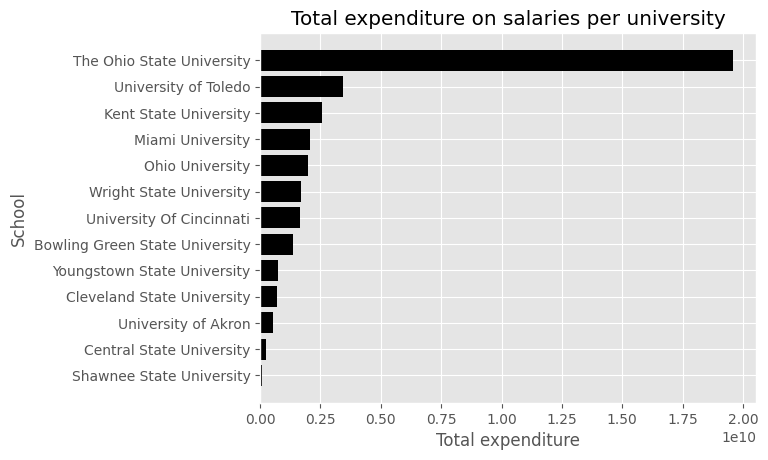

In [83]:
fig, ax = plt.subplots()
ax.barh(total_spend['School'],total_spend['total spend'],color='black' )
ax.set_title('Total expenditure on salaries per university')
ax.set_xlabel('Total expenditure')
ax.set_ylabel('School')
plt.gca().invert_yaxis()
plt.show()

In [121]:
#Create a copy of the dataframe
dfp = df.copy()

In [122]:
#Segment and reduce the number of classes in the 'Job' column to include only jobs that appear fewer than 5 times in the entire dataset, and then assign these less frequent jobs to a new category named 'Other'.
os = len(dfp['Job Description'].unique())
print('# of unique jobs before : {}'.format(os))

job_counts = dfp['Job Description'].value_counts()
mask = (job_counts < 5).values
jobs_to_replace = job_counts[mask].index
dfp['Job Description'] = dfp['Job Description'].apply(lambda x: 'other' if x in jobs_to_replace else x)

ns = len(dfp['Job Description'].unique())
print('# of unique jobs after : {}'.format(ns))

# of unique jobs before : 30226
# of unique jobs after : 9792


#Spliting the data
Splitting the data allows for the creation of training and evaluation subsets, facilitating an effective model training and assessment process.

In [123]:
X = dfp.drop(columns=['Earnings', 'Name'])
y = dfp['Earnings'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=24, test_size=0.4)

#Preprocessing the data

Preprocessing the dataset is crucial for achieving optimal model performance. As observed earlier, there are various steps to undertake without altering the original dataset distribution. Therefore, we have chosen to Label Encoder to convert categorical data into a numeric format and finally, a binary encoder to reduce the dimensionality of the Job and Department columns, enabling the models to effectively utilize all features.

In [124]:
lb_encoder = LabelEncoder()
X_train['School']=lb_encoder.fit_transform(X_train['School'])
X_test['School']=lb_encoder.fit_transform(X_test['School'])

encoder = ce.BinaryEncoder(cols=['Job Description','Department' ])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

#Determining the Optimal Parameters

Enabling us to identify the optimal parameter combinations for maximizing the performance of each model, this is supported by the GridSearchCV model, which provides us with increased confidence in its results.

In [126]:
estimator = xgb.XGBRegressor()
Params_grid = {
    'num_boost_round': [30,50,80],
    'max_depth': [1,2],
    'colsample_bytree':[0.7,1],
    'eta':[0.01,0.1],
    'samples':[0.5,0.8]
}

grid_mse = GridSearchCV(estimator = estimator, param_grid=Params_grid, scoring='neg_mean_squared_error',verbose=1, cv=3)
grid_mse.fit(X_train,y_train)

print(f'best params {grid_mse.best_params_}')
print(f'best score {(-grid_mse.best_score_)**0.5}')

Fitting 3 folds for each of 48 candidates, totalling 144 fits
best params {'colsample_bytree': 0.7, 'eta': 0.1, 'max_depth': 2, 'num_boost_round': 30, 'samples': 0.5}
best score 39950.672342990845


#Evaluating the Best Estimator from Grid Search
This process involves assessing the performance and behavior of the best estimator derived from grid search, providing valuable insights for informed decision-making based on its applicability to the specific problem at hand.


In [127]:
best_model = grid_mse.best_estimator_
pred = best_model.predict(X_test)


best_score = mean_squared_error(y_test, pred)**0.5
print(f'XGBRegressor RMSE : {best_score}')

XGBRegressor RMSE : 39947.144178972114


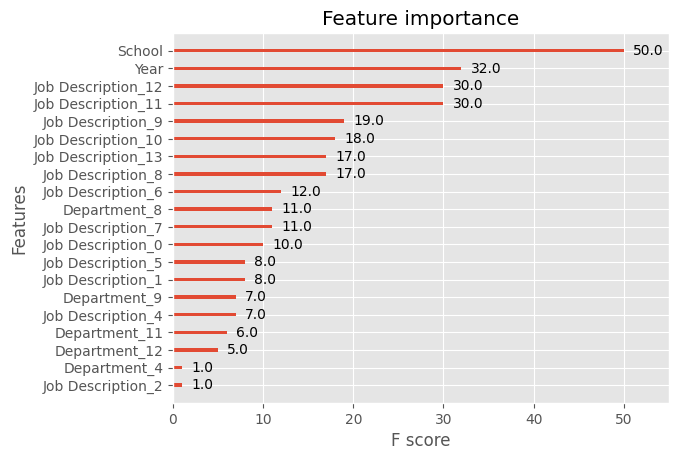

In [131]:
# Plot the feature importances
xgb.plot_importance(best_model)
plt.show()